In [79]:
%matplotlib inline
import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.wrapped_xgboost import xgboost_classifier
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'
nan_fill_value = -2.


In [2]:
nrows = 100000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),    index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file),   index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 22.0 seconds


In [3]:
print train_dat.shape, train_num.shape

(100000, 1156) (100000, 969)


In [4]:
train_dat.head(10)

,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
Id,,,,,,,,,,,,,,,,,,,,,
4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
tmp_train_num = train_num
tmp_train_dat = train_dat
#tmp_train_num = train_num.copy()
#tmp_train_dat = train_dat.copy()

In [6]:


def BasicDate_FeatureEngineering(tmp_train_dat):
    ## feature engineering on the date features
    encoder = preprocessing.LabelEncoder()
    column_names = tmp_train_dat.columns.tolist()
    column_names.append('NaN')
    encoder.fit(column_names)
    dat_new_fea = pd.DataFrame()
    dat_new_fea['start_time'] = tmp_train_dat['L0_S0_D1']
    dat_new_fea['time_sum'] = tmp_train_dat.sum(axis=1)
    dat_new_fea['time_mean'] = tmp_train_dat.mean(axis=1)
    dat_new_fea['dat_nan_count'] = tmp_train_dat.isnull().sum(axis=1)
    dat_new_fea['max_time'] = tmp_train_dat.max(axis=1)
    dat_new_fea['min_time'] = tmp_train_dat.min(axis=1)
    dat_new_fea['max_min_diff'] = dat_new_fea['max_time'] - dat_new_fea['min_time']
    dat_new_fea['max_min_ratio'] = dat_new_fea['min_time'] / dat_new_fea['max_time']

    dat_new_fea['idxmax'] = tmp_train_dat.idxmax(axis=1)
    dat_new_fea['idxmax'].fillna('NaN', inplace=True)
    dat_new_fea['idxmax'] = encoder.transform(dat_new_fea['idxmax'])
    dat_new_fea['idxmin'] = tmp_train_dat.idxmin(axis=1)
    dat_new_fea['idxmin'].fillna('NaN', inplace=True)
    dat_new_fea['idxmin'] = encoder.transform(dat_new_fea['idxmin'])
    return dat_new_fea


def getRelativeTimeColumns(series):
    '''
    normalize the time features by
    the start_time, the first none-NaN
    value
    '''
    if series[0] == np.NaN:
        start_time = series.dropna().index[0]
    else:
        start_time = series[0]
    new_series = series - start_time
    return new_series
   


def getTimeSteps(series, unique_value_counts = 5):
    '''
    in each row/series, use the sorted value_count
    to find the time steps and use the value, counts
    and column_index as features
    '''
    value_counts = series.value_counts()
    value_counts.sort_index(inplace=True)

    if 0. in value_counts.index:
        value_counts = value_counts[value_counts.index != 0.]
        
    available_counts = value_counts.shape[0]
    feature_array = []
    for i in xrange(unique_value_counts):
        if i < available_counts:
            value = value_counts.index[i]
            counts = value_counts[value]
            first_index = series[series == value].index[0]
            avg_time_cost = value / counts
            feature = [value, counts, avg_time_cost, first_index]
        else:
            feature = [np.NaN, np.NaN, np.NaN, np.NaN]
        feature_array.extend(feature)

    return pd.Series(feature_array)



def getTimeChangeColumns(series):
    start_time = series[0]
    tmp_series = series.dropna()
    if start_time == np.NaN:
        first_index = tmp_series.index[0]
        last_index  = tmp_series.index[-1]
        time_diff = tmp_series[last_index] - tmp_series[first_index]
        return pd.Series([first_index, last_index, time_diff])
    else:
        if np.sum(tmp_series != start_time) == 0:
            return pd.Series([np.NaN, np.NaN, np.NaN])
        else:
            first_index = tmp_series.index[tmp_series != start_time][0]
            last_index = tmp_series.index[tmp_series != start_time][-1]
            time_diff = tmp_series[last_index] - tmp_series[first_index]
            return pd.Series([first_index, last_index, time_diff])


        
def getNonNaN_ColumIndex(series):
    if series.notnull().sum() == 0:
        return pd.Series([np.NaN, np.NaN, np.NaN])
    else:
        first_id = series[series.notnull()].index[0]
        last_id = series[series.notnull()].index[-1]
        time_diff = series[last_id] - series[first_id]
        return pd.Series([first_id, last_id, time_diff])



    
    
def DateFeatureEngineering(series):
    '''
    combination of time difference features and none-NaN features    
    this method is faster than separating two functions
    '''
    ## time features
    start_time = series[0]
    tmp_series = series.dropna()
    if start_time == np.NaN:
        first_index = tmp_series.index[0]
        last_index  = tmp_series.index[-1]
        time_diff   = tmp_series[last_index] - tmp_series[first_index]
        time_fea    = np.array([first_index, last_index, time_diff])
    else:
        if np.sum(tmp_series != start_time) == 0:
            time_fea = np.array([np.NaN, np.NaN, np.NaN])
        else:
            first_index = tmp_series.index[tmp_series != start_time][0]
            last_index  = tmp_series.index[tmp_series != start_time][-1]
            time_diff   = tmp_series[last_index] - tmp_series[first_index]
            time_fea = np.array([first_index, last_index, time_diff])
    ## none-NaN features
    if series.notnull().sum() == 0:
        nan_fea = np.array([np.NaN, np.NaN, np.NaN])
    else:
        first_id  = tmp_series.index[0]
        last_id   = tmp_series.index[-1]
        time_diff = tmp_series[last_id] - tmp_series[first_id]
        nan_fea = np.array([first_id, last_id, time_diff])
         
    new_fea_row = np.concatenate([time_fea, nan_fea])
    return pd.Series(new_fea_row)

In [68]:


def NumericalFeatureEngineering(df, col_ignore = ['Response']):
    tmp_df = df.loc[:, ~df.columns.isin(col_ignore)]
    new_fea_df = pd.DataFrame()
    encoder = preprocessing.LabelEncoder()
    column_names = tmp_df.columns.tolist()
    column_names.append('NaN')
    encoder.fit(column_names)
    new_fea_df['num_sum'] = tmp_df.sum(axis=1)
    num_sum_max = new_fea_df['num_sum'].max()
    new_fea_df['num_sum'].fillna(1.*int(num_sum_max - 5), inplace=True)
    new_fea_df['num_max'] = tmp_df.max(axis=1)
    num_max_max = new_fea_df['num_max'].max()
    new_fea_df['num_max'].fillna(1.*int(num_max_max + 1), inplace=True)
    new_fea_df['num_min'] = tmp_df.min(axis=1)
    num_min_min = new_fea_df['num_min'].min()
    new_fea_df['num_min'].fillna(1.*int(num_min_min - 1.), inplace=True)
    new_fea_df['mun_max_min_ratio'] = new_fea_df['num_min'] / new_fea_df['num_max']
    new_fea_df['mun_max_min_ratio'] = new_fea_df['mun_max_min_ratio'].replace([np.inf, -np.inf], 1100.)
    new_fea_df['num_nan_col_count'] = tmp_df.isnull().sum(axis=1)
    new_fea_df['num_reg_col_count'] = tmp_df.shape[1] - tmp_df.isnull().sum(axis=1)
    new_fea_df['idxmax'] = tmp_df.idxmax(axis=1)
    new_fea_df['idxmax'].fillna('NaN', inplace=True)
    new_fea_df['idxmax'] = encoder.transform(new_fea_df['idxmax'])
    new_fea_df['idxmin'] = tmp_df.idxmin(axis=1)
    new_fea_df['idxmin'].fillna('NaN', inplace=True)
    new_fea_df['idxmin'] = encoder.transform(new_fea_df['idxmin'])
    return new_fea_df


In [69]:
tmp_train_num_Basics = NumericalFeatureEngineering(tmp_train_num)

In [70]:
print tmp_train_num_Basics.min().min(), tmp_train_num_Basics.max().max()

-1936.0 1100.0


In [15]:
#print tmp_train_num.max().max(), '\n', tmp_train_num.min().min()
tmp_train_num.fillna(nan_fill_value, inplace=True)

1.0 
-1.0


In [71]:
combined_train_num = pd.concat([tmp_train_num, tmp_train_num_Basics], axis=1)

In [30]:
print combined_train_num.isnull().sum().sum()

0


In [32]:
start_time = time.time()

## normalized date columns
tmp_train_dat_Norm = tmp_train_dat.apply(getRelativeTimeColumns, axis=1)
## basic features from tmp_train_dat
tmp_train_dat_Basics = BasicDate_FeatureEngineering(tmp_train_dat)

encoder = preprocessing.LabelEncoder()
column_names = tmp_train_dat.columns.tolist()
column_names.append('NaN')
encoder.fit(column_names)
    
#'''
tmp_train_dat_TimeDiff = tmp_train_dat.apply(getTimeChangeColumns, axis=1)
tmp_train_dat_TimeDiff.columns = ['time_diff_start_col', 'time_diff_end_col', 'time_diff_value']
                   
for column in ['time_diff_start_col', 'time_diff_end_col']:
    tmp_train_dat_TimeDiff[column].fillna('NaN', inplace=True)
    tmp_train_dat_TimeDiff[column] = encoder.transform(tmp_train_dat_TimeDiff[column])  
    
#'''


unique_value_counts = 5
timeStep_columnNames = []
column_name_columns = []
for i in xrange(unique_value_counts):
    timeStep_columnNames.extend(['time_diff_step_{}'.format(i), 'column_counts_step_{}'.format(i), 
                                 'time_cost_step_{}'.format(i), 'first_column_step_{}'.format(i)])
    column_name_columns.append('first_column_step_{}'.format(i))

tmp_train_dat_TimeStep = tmp_train_dat_Norm.apply(getTimeSteps, axis=1)
tmp_train_dat_TimeStep.columns = timeStep_columnNames
for column in column_name_columns:
    tmp_train_dat_TimeStep[column].fillna('NaN', inplace=True)
    tmp_train_dat_TimeStep[column] = encoder.transform(tmp_train_dat_TimeStep[column])
    

print 'finish feature engineering date using {} minutes'.format(round((time.time() - start_time)/60, 2))

finish feature engineering date using 7.24 minutes


In [ ]:
'''
print tmp_train_dat_Norm.shape
tmp_train_dat_Norm.head()

print tmp_train_dat_TimeStep.shape
tmp_train_dat_TimeStep.head()

print tmp_train_dat_TimeDiff.shape
tmp_train_dat_TimeDiff.head()

print tmp_train_dat_Basics.shape
tmp_train_dat_Basics.head()
'''

In [33]:
combined_train_dat = pd.concat([tmp_train_dat_Norm, tmp_train_dat_Basics, tmp_train_dat_TimeDiff, tmp_train_dat_TimeStep], axis=1)

In [34]:
print combined_train_dat.max().max(), combined_train_dat.min().min()

556416.2 0.0


In [35]:
combined_train_dat.fillna(nan_fill_value, inplace=True)

In [36]:
print combined_train_dat.isnull().sum().sum()

0


In [72]:
combined_train = pd.concat([combined_train_num, combined_train_dat], axis=1)

In [38]:
print combined_train.shape
combined_train.head()

(100000, 2166)


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,time_cost_step_2,first_column_step_2,time_diff_step_3,column_counts_step_3,time_cost_step_3,first_column_step_3,time_diff_step_4,column_counts_step_4,time_cost_step_4,first_column_step_4
Id,,,,,,,,,,,,,,,,,,,,,
4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,0.050707,883,5.03,4.0,1.257500,1014,5.04,15.0,0.336000,1019
6,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,...,-2.000000,1156,-2.00,-2.0,-2.000000,1156,-2.00,-2.0,-2.000000,1156
7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,0.090476,883,5.71,68.0,0.083971,946,5.72,29.0,0.197241,1019
9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,0.078095,883,4.93,68.0,0.072500,946,4.94,10.0,0.494000,1019
11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,0.025649,883,3.37,15.0,0.224667,1019,3.38,14.0,0.241429,1042


In [239]:
#combined_train = combined_train_dat
#combined_train[dep_var_name] = combined_train_num[dep_var_name]

In [73]:
############## Section of regular validation #######################
train_index, valid_index = create_validation_index(combined_train, 0.3, dep_var_name, True)
valid_data = combined_train.ix[valid_index]
tmp_train  = combined_train.ix[train_index]

In [74]:
y = tmp_train[dep_var_name].values
X = tmp_train.drop(dep_var_name, axis=1)

valid_y = valid_data[dep_var_name].values
valid_X = valid_data.drop(dep_var_name, axis=1)

In [75]:
rf_params = {'random_state' : 9999, 'n_estimators' : 2000, 'max_depth' : 7, 'criterion' : 'gini', 'n_jobs' : -1}
et_params = {'random_state' : 9999, 'n_estimators' : 200, 'max_depth' : 18, 'criterion' : 'gini', 'n_jobs' : -1}
rf_clf = RandomForestClassifier(**rf_params)
rf_clf = rf_clf.fit(X, y)

et_clf = RandomForestClassifier(**et_params)
et_clf = et_clf.fit(X, y)

In [247]:
C = 0.1
start_time = time.time()
LR_clf = LogisticRegression(C = C, class_weight='balanced', n_jobs = -1, penalty='l2')
LR_clf.fit(X, y)
print 'finish training LR model using {} seconds'.format(round(time.time() - start_time, 0))

finish training LR model using 242.0 seconds


In [81]:
params = {}
params["eta"]                      = 0.0075
params["subsample"]                = 0.8
params["colsample_bytree"]         = 0.8
params["num_round"]                = 2000
params["max_depth"]                = 5
params["gamma"]                    = 0
params["metrics"]                  = 'auc'
params['eval_metric']              = 'auc'
params["seed"]                     = 999
params['verbose_eval']             = 50
## whether to use weights
params['use_base_score']           = True
params['use_weights']              = True
#params['use_scale_pos_weight']     = True
params["val"]                      = False

model = xgboost_classifier(label_name = dep_var_name, params = params, model_file='bosch_xgb_model')
model.fit(tmp_train, dep_var_name)

scale_pos_weight: 174.881909548
a base_score 0.00568563306238 is used in the xgboost model...



####################
 train the xgboost without early stopping
####################


[0]	train-auc:0.719957
[50]	train-auc:0.837319
[100]	train-auc:0.849805
[150]	train-auc:0.878313
[200]	train-auc:0.900251
[250]	train-auc:0.920368
[300]	train-auc:0.936107
[350]	train-auc:0.94872
[400]	train-auc:0.959309
[450]	train-auc:0.965316
[500]	train-auc:0.971164
[550]	train-auc:0.975505
[600]	train-auc:0.978556
[650]	train-auc:0.981243
[700]	train-auc:0.984397
[750]	train-auc:0.987084
[800]	train-auc:0.988832
[850]	train-auc:0.990672
[900]	train-auc:0.992029
[950]	train-auc:0.993165
[1000]	train-auc:0.99409
[1050]	train-auc:0.9947
[1100]	train-auc:0.995434
[1150]	train-auc:0.99613
[1200]	train-auc:0.996666
[1250]	train-auc:0.996992
[1300]	train-auc:0.99727
[1350]	train-auc:0.997605
[1400]	train-auc:0.997867
[1450]	train-auc:0.998081
[1500]	train-auc:0.99826
[1550]	train-auc:0.998398
[1600]	train-auc:0.998535
[1650]	train-auc:0.998665
[1700]	train-auc:0.998775
[1750]	train-auc:0.998874
[1800]	train-auc:0.998961
[1850]	train-auc:0.999045
[1900]	train-auc:0.999129
[1950]	train-auc

In [83]:
#pred = rf_clf.predict_proba(valid_X)[:, 1]
#pred = et_clf.predict_proba(valid_X)[:, 1]
#pred = LR_clf.predict_proba(valid_X)[:, 1]
pred = model.predict(valid_X)

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

in the prediction step, dep_var_name is not provided....
result from using constant fraction: 
mean of groud truth: 0.00566685556185
threshold for preds: 0.0325735116611
0.201356555898

 

result from using flexsible threshold: (0.23640114182377825, 0.04184843227267265)


In [ ]:
et_params = {'random_state' : 9999, 'n_estimators' : 200, 'max_depth' : 18, 'criterion' : 'gini', 'n_jobs' : -1}

### R&D work

Independent work to build LR models on both numerical and date features. Those LR
models will be used as feature selection tools.

    1. use all the numerical/date data and only first 50,000 rows
    2. try to build a LR model and understand the features

In [34]:
## select all the numerical columns and try to use LR
start_time = time.time()
train_num  = pd.read_csv(join(data_path, train_num_file),    index_col='Id', skiprows=skipped_train_row_num, nrows=50000)
train_date = pd.read_csv(join(data_path, train_date_file),   index_col='Id', skiprows=skipped_train_row_num, nrows=50000)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 13.0 seconds


In [35]:
print train_date.max().max(), train_date.min().min()

1717.86 0.39


In [36]:
## remove columns that mostly just NaN
train_num.fillna(-1., inplace=True)
train_date.fillna(-1., inplace=True)

In [37]:
start_time = time.time()
train_num_corr = train_num.corr()
train_date_corr = train_date.corr()
print 'finish calculating correlation using {} seconds'.format(round(time.time() - start_time, 0))

finish calculating correlation using 261.0 seconds


In [38]:
print train_num_corr.shape, train_date_corr.shape

(969, 969) (1156, 1156)


In [26]:
#train_date_corr

In [39]:
start_index = 0
thres = 0.5
num_removed_cols = set()
dat_removed_cols = set()

for column in train_num_corr.columns:
    start_index += 1
    if column not in num_removed_cols:
        for index, value in enumerate(train_num_corr[column][start_index:]):
            if abs(value) > thres:
                num_removed_cols.add(train_num_corr.columns[(index + start_index)])
               
start_index = 0           
for column in train_date_corr.columns:
    start_index += 1
    if column not in dat_removed_cols:
        for index, value in enumerate(train_date_corr[column][start_index:]):
            if abs(value) > thres:
                dat_removed_cols.add(train_date_corr.columns[(index + start_index)])

In [40]:
print len(num_removed_cols), len(dat_removed_cols), train_num_corr.shape[1], train_date_corr.shape[1]

921 1108 969 1156


In [41]:
max_corr_fea = train_num_corr['Response'][:-1].argmax()
min_corr_fea = train_num_corr['Response'][:-1].argmin()

In [42]:
print train_num_corr['Response'][:-1].max(), max_corr_fea, '\n', train_num_corr['Response'][:-1].min(), min_corr_fea

0.0893626579396 L3_S32_F3850 
-0.0569501205985 L3_S33_F3869


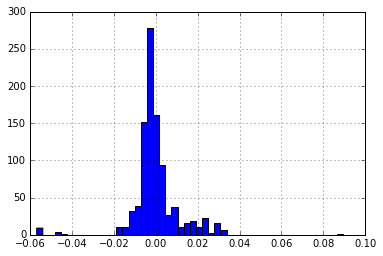

In [43]:
train_num_corr['Response'][:-1].hist(bins=50)

In [44]:
selected_num_col_names = [col for col in train_num.columns if col not in num_removed_cols]
selected_dat_col_names = [col for col in train_date.columns if col not in dat_removed_cols]

In [45]:
print len(selected_num_col_names), len(selected_dat_col_names)

48 48


In [46]:
selected_num_col_names.extend(['Id', 'Response'])
selected_dat_col_names.extend(['Id'])

load data using the selected columns.
train_num and train_cat data will be combined and used as a whole for the LR model training

In [47]:
start_time = time.time()
full_train_num  = pd.read_csv(join(data_path, train_num_file),    index_col='Id', skiprows=skipped_train_row_num, usecols=selected_num_col_names)
full_train_cat  = pd.read_csv(join(data_path, train_date_file),   index_col='Id', skiprows=skipped_train_row_num, usecols=selected_dat_col_names)
print 'finish loading full data using {} seconds'.format(round(time.time() - start_time, 0))

finish loading full data using 34.0 seconds


In [73]:
tmp_train_num = full_train_num.copy()
tmp_train_cat = full_train_cat.copy()

## remove columns that mostly just NaN
tmp_train_num.fillna(-1., inplace=True)
tmp_train_cat.fillna(-1., inplace=True)

print tmp_train_num.shape, tmp_train_cat.shape

(509886, 48) (509886, 48)


In [74]:
combined_train = pd.merge(tmp_train_num, tmp_train_cat, how='outer', left_index=True, right_index=True)

In [75]:
print combined_train.shape, dep_var_name in combined_train.columns
combined_train.head()

(509886, 96) True


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S39_D3966,L3_S42_D4029,L3_S42_D4033,L3_S42_D4037,L3_S42_D4041,L3_S42_D4045,L3_S42_D4049,L3_S42_D4053,L3_S42_D4057,L3_S46_D4135
Id,,,,,,,,,,,,,,,,,,,,,
6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
14,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
41,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [76]:
############## Section of regular validation #######################
train_index, valid_index = create_validation_index(combined_train, 0.3, dep_var_name, True)
valid_data = combined_train.ix[valid_index]
tmp_train  = combined_train.ix[train_index]

In [77]:
y = tmp_train[dep_var_name].values
X = tmp_train.drop(dep_var_name, axis=1)

valid_y = valid_data[dep_var_name].values
valid_X = valid_data.drop(dep_var_name, axis=1)

In [78]:
print X.shape, valid_X.shape

(356921, 95) (152965, 95)


In [79]:
C = 0.01

In [80]:
start_time = time.time()
LR_clf = LogisticRegression(C = C, class_weight='balanced', n_jobs = -1, penalty='l2')
LR_clf.fit(X, y)
print 'finish training LR model using {} seconds'.format(round(time.time() - start_time, 0))

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [81]:
pred = LR_clf.predict_proba(valid_X)[:, 1]

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

result from using constant fraction: 
mean of groud truth: 0.00641323178505
threshold for preds: 0.907512666314
0.079724974269

 

result from using flexsible threshold: (0.10051449974313409, 0.7422325440755092)


In [82]:
coef_l1_LR = LR_clf.coef_.ravel()

In [83]:
len(coef_l1_LR)

95

(array([ 26.,   1.,   1.,   1.,   1.,  37.,   2.,   3.,   2.,   2.,   2.,
          4.,   0.,   1.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([  1.04347182e-04,   2.50598160e-02,   5.00152849e-02,
          7.49707537e-02,   9.99262225e-02,   1.24881691e-01,
          1.49837160e-01,   1.74792629e-01,   1.99748098e-01,
          2.24703567e-01,   2.49659036e-01,   2.74614504e-01,
          2.99569973e-01,   3.24525442e-01,   3.49480911e-01,
          3.74436380e-01,   3.99391849e-01,   4.24347317e-01,
          4.49302786e-01,   4.74258255e-01,   4.99213724e-01,
          5.24169193

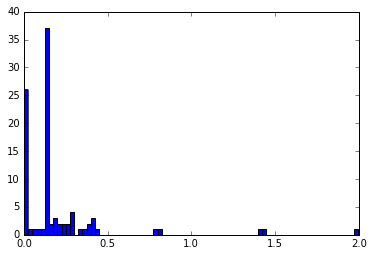

In [99]:
plt.hist(abs(coef_l1_LR), bins=80)

In [90]:
print np.argmax(coef_l1_LR), np.argmin(coef_l1_LR)

41 40


In [91]:
sorted_index = np.argsort(abs(coef_l1_LR))

In [104]:
coef_l1_LR[sorted_index][-19:]

array([ 0.25730656, -0.27214237,  0.27717454, -0.28075841,  0.28671067,
       -0.2958737 ,  0.33863482,  0.36509587, -0.3821762 ,  0.38715437,
       -0.40161981, -0.4058657 ,  0.41581182,  0.44451443,  0.77817978,
        0.80855061,  1.4200994 ,  1.44046263,  1.99654185])

In [94]:
## data used in model training
print X.shape

(356921, 95)


In [105]:
X.columns[sorted_index[-19:]]

Index([u'L3_S38_F3952', u'L0_S23_F619', u'L1_S25_F1855', u'L1_S25_F2799',
       u'L3_S29_F3379', u'L1_S24_F1808', u'L1_S24_F679', u'L1_S25_F2498',
       u'L1_S24_F1118', u'L3_S49_F4206', u'L0_S22_F546', u'L3_S31_F3834',
       u'L3_S29_F3464', u'L3_S50_F4243', u'L2_S28_F3222', u'L1_S25_F2231',
       u'L1_S24_F1581', u'L1_S24_F1672', u'L3_S32_F3850'],
      dtype='object')

In [100]:
X.columns[sorted_index]

Index([u'L0_S22_D543', u'L1_S24_D677', u'L3_S38_D3953', u'L3_S35_D3886',
       u'L1_S25_D2206', u'L1_S25_D1854', u'L2_S26_D3037', u'L1_S25_D2180',
       u'L1_S25_D2879', u'L3_S32_D3852', u'L1_S25_D2801', u'L2_S27_D3130',
       u'L2_S28_D3223', u'L1_S25_D2957', u'L1_S25_D2471', u'L1_S24_D1116',
       u'L1_S24_D1511', u'L1_S25_D2230', u'L0_S1_D26', u'L1_S25_D2754',
       u'L3_S39_D3966', u'L0_S12_D331', u'L3_S29_D3316', u'L1_S25_D2497',
       u'L3_S31_D3836', u'L1_S25_F2960', u'L3_S30_F3564', u'L1_S25_F2877',
       u'L1_S25_F2755', u'L0_S1_F24', u'L0_S0_D7', u'L0_S0_D13', u'L0_S0_D9',
       u'L0_S0_D11', u'L0_S0_D15', u'L0_S0_F0', u'L0_S0_D19', u'L0_S0_D21',
       u'L0_S0_D23', u'L1_S24_D1158', u'L0_S0_D5', u'L0_S0_D17', u'L0_S0_D3',
       u'L0_S0_D1', u'L3_S46_D4135', u'L0_S0_F20', u'L0_S0_F18', u'L0_S0_F16',
       u'L0_S0_F14', u'L0_S0_F12', u'L0_S0_F10', u'L0_S0_F8', u'L0_S0_F6',
       u'L0_S0_F22', u'L0_S0_F4', u'L0_S0_F2', u'L3_S42_D4045',
       u'L3_S42_D4057', u'L3_S4

In [86]:
print tmp_train_num.columns[np.argmax(coef_l1_LR)], tmp_train_num.columns[np.argmin(coef_l1_LR)]

L3_S32_F3850 L0_S8_F144
